# Movie Recommendation

In this notebook, I will use an Alternating Least Squares (ALS) algorithm with Spark API to predict the ratings for movie provided by MovieLens

## Part 0: Set up environments
### Spark

In [1]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Download Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
# Unzip the file
!tar xf spark-3.4.1-bin-hadoop3.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.4.1-bin-hadoop3'

# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.4.1-bin-hadoop3'

In [2]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [3]:
# Import a Spark function from library
from pyspark.sql.functions import col

### Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/Colab\ Notebooks/ml-latest-small/

/content/drive/MyDrive/Colab Notebooks/ml-latest-small


In [7]:
ls

links.csv    spark-3.4.1-bin-hadoop3/       spark-3.4.1-bin-hadoop3.tgz.3
movies.csv   spark-3.4.1-bin-hadoop3.tgz    tags.csv
ratings.csv  spark-3.4.1-bin-hadoop3.tgz.1
README.txt   spark-3.4.1-bin-hadoop3.tgz.2


In [8]:
movies_df = spark.read.load("drive/MyDrive/Colab\ Notebooks/ml-latest-small/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("drive/MyDrive/Colab\ Notebooks/ml-latest-small/ratings.csv", format='csv', header = True)
links_df = spark.read.load("drive/MyDrive/Colab\ Notebooks/ml-latest-small/links.csv", format='csv', header = True)
tags_df = spark.read.load("drive/MyDrive/Colab\ Notebooks/ml-latest-small/tags.csv", format='csv', header = True)

In [9]:
movies_df.show(5)


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [10]:
 ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [11]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [12]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [13]:
min_rate_user = ratings_df.groupBy("userId").count().agg({"count": 'min'}).toPandas()
min_rate_movie = ratings_df.groupBy("movieId").count().agg({"count": 'min'}).toPandas()
print ("Minimum number of rating per user is:", min_rate_user.iloc[0,0])
print ("Minimum number of rating per movie is:", min_rate_movie.iloc[0,0])

Minimum number of rating per user is: 20
Minimum number of rating per movie is: 1


Understand data distribution helps us determen which model to use

In [14]:
total_rating = ratings_df.select("movieId").distinct().count()
just1_rating = ratings_df.groupBy("movieId").count().where('count=1').count()

print("Total rating num is: ", total_rating)
print("one rating num is: ", just1_rating)

Total rating num is:  9724
one rating num is:  3446


## Part 1: OLAP with Spark SQL

In [15]:
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")
links_df.createOrReplaceTempView("links")
tags_df.createOrReplaceTempView("tags")

###Total number of users

In [16]:
total_user=spark.sql("SELECT COUNT(DISTINCT userID) FROM ratings " +\
                      "UNION SELECT COUNT(DISTINCT userID) FROM tags ").toPandas()

print(total_user)
print()
print()




print("Total num of user: " + str(total_user.iloc[0,0]))

   count(DISTINCT userID)
0                     610
1                      58


Total num of user: 610


### Total numbers of movies

In [17]:
total_movies = spark.sql("SELECT COUNT(DISTINCT movieId) FROM movies").toPandas()
total_movies

,count(DISTINCT movieId)
0,9742


incase there are missing data

In [18]:
incase_total_movies = spark.sql("SELECT COUNT(DISTINCT movieId) FROM movies " +\
                          "UNION SELECT COUNT(DISTINCT movieId) FROM ratings " +\
                          "UNION SELECT COUNT(DISTINCT movieId) FROM links " +\
                          "UNION SELECT COUNT(DISTINCT movieId) FROM tags ").toPandas()
incase_total_movies

,count(DISTINCT movieId)
0,9742
1,9724
2,1572


In [19]:
print('Total number of movies: ' + str(incase_total_movies.iloc[0,0]))

Total number of movies: 9742


### Number of movie rated and Movies that is not rated

In [20]:
num_rated_moovies = spark.sql("SELECT COUNT(DISTINCT movieId) FROM ratings").toPandas()
num_rated_moovies

,count(DISTINCT movieId)
0,9724


In [21]:
print("Number movie rated: " + str(num_rated_moovies.iloc[0,0]))

Number movie rated: 9724


In [22]:
movies_not_rated = spark.sql("SELECT * FROM movies WHERE movieId NOT IN (SELECT movieId FROM ratings)").toPandas()

movies_not_rated

,movieId,title,genres
0,1076,"Innocents, The (1961)",Drama|Horror|Thriller
1,2939,Niagara (1953),Drama|Thriller
2,3338,For All Mankind (1989),Documentary
3,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
4,4194,I Know Where I'm Going! (1945),Drama|Romance|War
5,5721,"Chosen, The (1981)",Drama
6,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance
7,6849,Scrooge (1970),Drama|Fantasy|Musical
8,7020,Proof (1991),Comedy|Drama|Romance
9,7792,"Parallax View, The (1974)",Thriller


In [23]:
ratings_pd = spark.sql("SELECT * FROM ratings").toPandas()
ratings_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     100836 non-null  object
 1   movieId    100836 non-null  object
 2   rating     100836 non-null  object
 3   timestamp  100836 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


In [24]:
top_num_ratings = spark.sql("SELECT title, count(*) AS count FROM movies as a " +\
                            "INNER JOIN ratings as b ON a.movieId = b.movieId GROUP BY 1 ORDER BY 2 DESC LIMIT 40").toPandas()
top_num_ratings


,title,count
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220


Text(0, 0.5, 'Title')

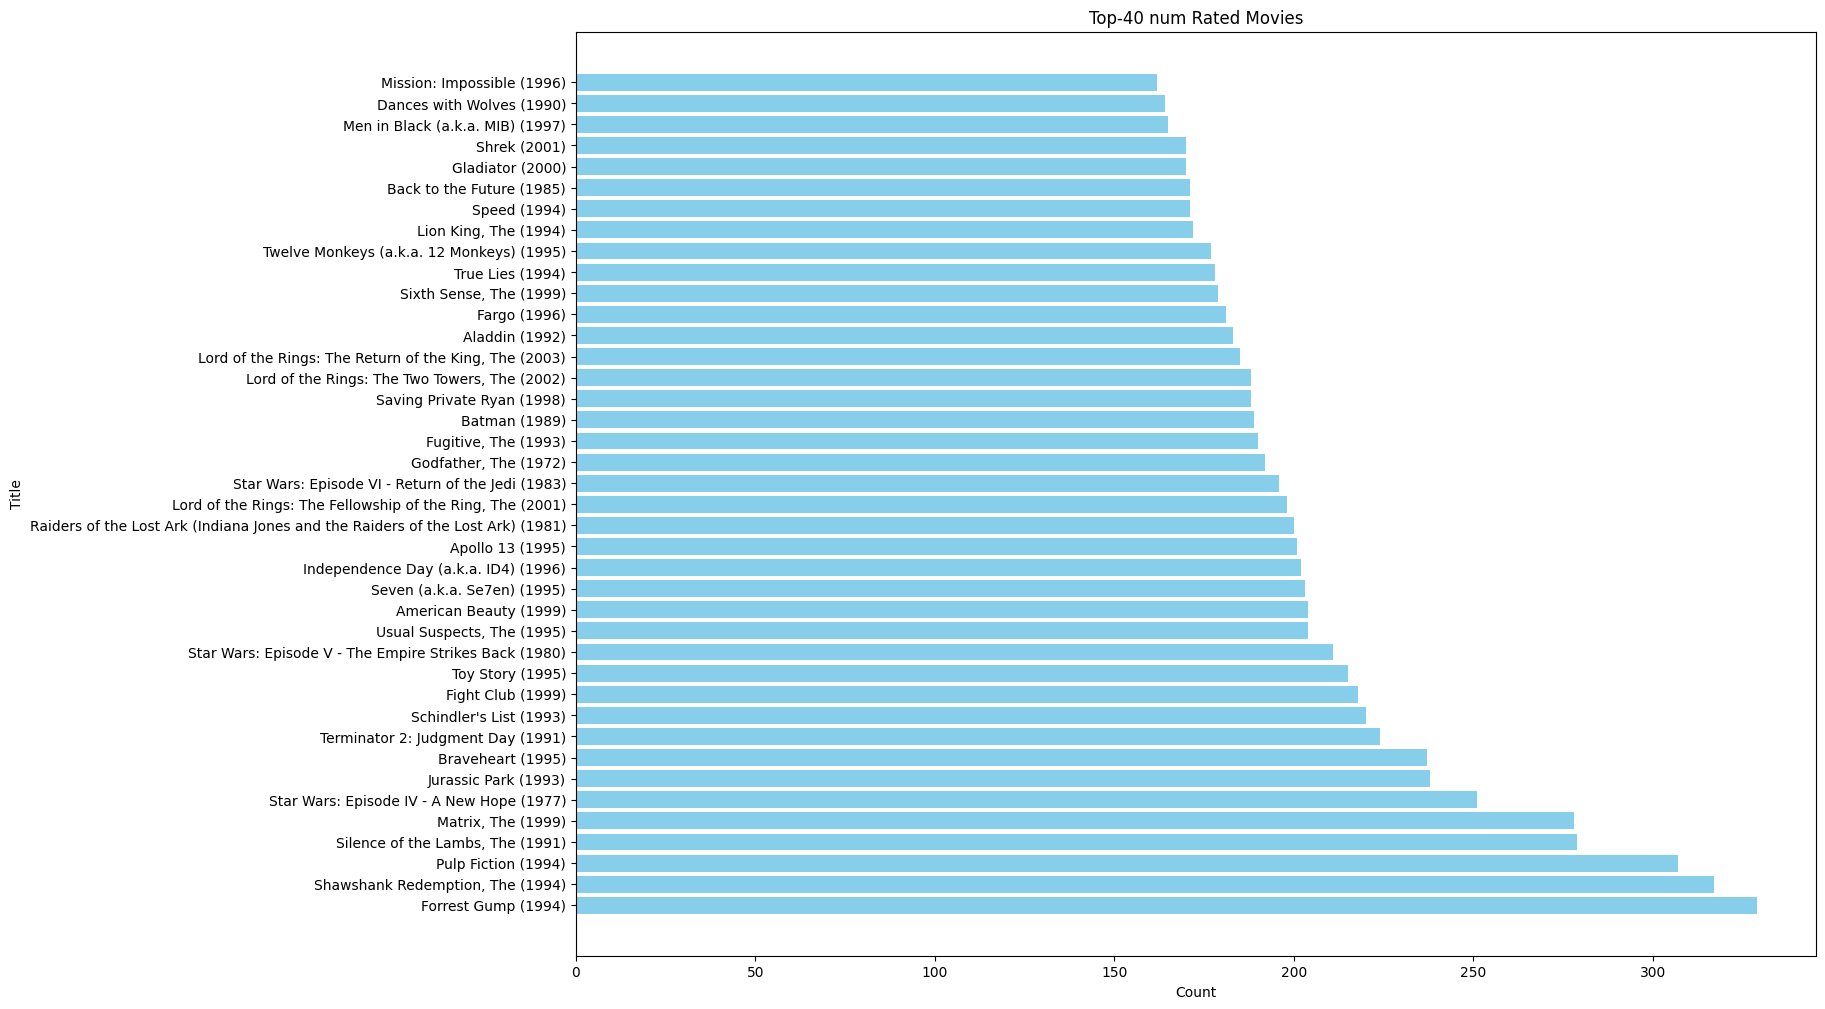

In [25]:
plt.figure(figsize=[16,12])
plt.barh(y='title',width='count',data=top_num_ratings, color='skyblue')
plt.title('Top-40 num Rated Movies')
plt.xlabel('Count')
plt.ylabel('Title')


### Movie Genres

In [26]:
spark.sql("SELECT DISTINCT genres FROM movies").show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
| Adventure|Animation|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Comedy|Crime|Horr...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Horror|Romance|Sc...|
|Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows



In [27]:
list_genres = spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by 1")
list_genres.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



### Number of movie/ movie in each category

In [28]:
num_movie_category = spark.sql("SELECT genres, count(movieId) FROM (SELECT movieId, explode(split(genres,'[|]')) " +\
                               "as genres From movies) GROUP BY 1 ORDER BY 2 DESC ")
num_movie_category.show()

+------------------+--------------+
|            genres|count(movieId)|
+------------------+--------------+
|             Drama|          4361|
|            Comedy|          3756|
|          Thriller|          1894|
|            Action|          1828|
|           Romance|          1596|
|         Adventure|          1263|
|             Crime|          1199|
|            Sci-Fi|           980|
|            Horror|           978|
|           Fantasy|           779|
|          Children|           664|
|         Animation|           611|
|           Mystery|           573|
|       Documentary|           440|
|               War|           382|
|           Musical|           334|
|           Western|           167|
|              IMAX|           158|
|         Film-Noir|            87|
|(no genres listed)|            34|
+------------------+--------------+



In [29]:
titles_movie_category = spark.sql("SELECT genres, concat_ws(',',collect_set(title)) AS list_of_title FROM(SELECT title, explode(split(genres,'[|]')) " +\
                               "as genres From movies) GROUP BY 1")
titles_movie_category.show()

+------------------+--------------------+
|            genres|       list_of_title|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

# Part2: Spark ALS based approach for training model
I will use an Spark ML to predict the ratings.


### Background Info
This is a collaborative filtering, from it using matrix factorization to solve for sparse data problem


The loss function I am using is Alternating Least Square (ALS), a matrix factorization algorithm and it runs it selfs in parallel.

Iteration:
Fix Users, Optimize Items
Fix Items, Optimize Users

ALS is doing a pretty good job at solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets.

In [30]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [31]:
movie_ratings = ratings_df.drop("timestamp")

In [32]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [33]:
movie_ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)



Convert data type

In [34]:
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [35]:
movie_ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)



In [36]:
movie_ratings.select("rating").show()

+------+
|rating|
+------+
|   4.0|
|   4.0|
|   4.0|
|   5.0|
|   5.0|
|   3.0|
|   5.0|
|   4.0|
|   5.0|
|   5.0|
|   5.0|
|   5.0|
|   3.0|
|   5.0|
|   4.0|
|   5.0|
|   3.0|
|   3.0|
|   5.0|
|   4.0|
+------+
only showing top 20 rows



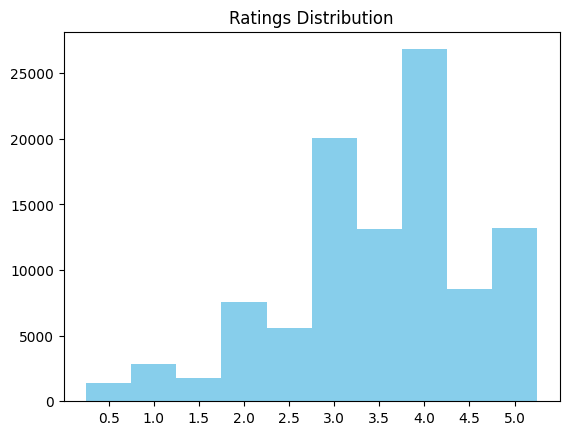

In [37]:
ratings_distribution = movie_ratings.groupBy("rating").count().toPandas()
plt.bar(x='rating',height='count',data=ratings_distribution,width=0.5, color = "skyblue")
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()

#### Model Training and Hyperparameters selection

In [38]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

Train Test set

In [39]:
train, test = movie_ratings.randomSplit([0.8,0.2], seed = 421)

ALS Model

In [40]:
model_als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", seed=421)

RMSE Evaluator

In [41]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

Tune Model

In [42]:
parameters = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [3, 5,10])\
            .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
            .addGrid(model_als.alpha, [0.1, 0.01, 0.001]).build()

cv_creator=CrossValidator(estimator=model_als, estimatorParamMaps=parameters,
                          evaluator=evaluator,numFolds=4,seed=421)

cv_model=cv_creator.fit(train)



In [43]:
best_parameters=cv_model.getEstimatorParamMaps()[np.argmin(cv_model.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_parameters.items():
  print(i.name + ": " + str(j))


Best ALS model parameters by CV:
maxIter: 10
regParam: 0.1
rank: 5
alpha: 0.1


In [44]:
prediction_train=cv_model.transform(train)
rmse_train = evaluator.evaluate(prediction_train)
print("ALS CV Root-mean-square error: " + str(rmse_train))

ALS CV Root-mean-square error: 0.6381181359057608


# Part 3: Model Testing

See the test error

In [45]:
best_model = cv_model.bestModel
test_prediction = best_model.transform(test)
test_rmse = evaluator.evaluate(test_prediction)
print("Test RMSE: " + str(test_rmse))

Test RMSE: 0.8830961776198542


In [46]:
test_prediction.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|   4886|   3.0| 3.6444569|
|   148|   6377|   3.0|  3.943509|
|   148|  31658|   4.0| 3.9071765|
|   148|  50872|   3.0| 3.6010418|
|   148|  68954|   4.0| 4.0554643|
|   148|  69844|   4.0| 3.7247283|
|   148|  89745|   4.0| 3.2141993|
|   148|  98243|   4.5| 3.4409924|
|   148| 110102|   4.0| 2.6311343|
|   148| 115617|   3.5| 3.6429977|
|   148| 160718|   4.5|  3.796887|
|   463|    110|   4.5| 4.0042763|
|   463|    780|   3.5| 3.3911664|
|   463|   1088|   3.5| 3.3426723|
|   463|   1221|   4.5| 4.0660796|
|   463|   1320|   4.0| 3.2531943|
|   463|   1552|   4.5|  3.166183|
|   463|   2019|   4.0| 4.1245537|
|   463|   3448|   3.0|   3.63772|
|   463|   4223|   4.0| 3.7060714|
+------+-------+------+----------+
only showing top 20 rows



# Apply the model for entire data set and prepare for recommend

In [47]:
entire_data = best_model.transform(movie_ratings)
entire_rmse = evaluator.evaluate(entire_data)
print("Full data RMSE: " + str(entire_rmse))


Full data RMSE: 0.6929641748406531


prepare data frame for spark SQL

In [48]:
entire_data.createOrReplaceTempView("entire_data")

In [49]:
spark.sql("SELECT * FROM entire_data").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.5| 3.3426723|
|   137|   1580|   3.5| 3.2560744|
|   580|   1580|   4.0| 3.4323025|
|   580|   3175|   2.5|  3.252576|
|   580|  44022|   3.5| 3.4993315|
|   133|    471|   4.0| 3.0950043|
|   322|   1580|   3.5| 3.0953631|
|   362|   1591|   4.0| 3.0338264|
|   362|   1645|   5.0| 3.7926078|
|   593|   1580|   1.5| 3.0438175|
|   597|    471|   2.0|  3.776999|
|   597|   1580|   3.0| 3.5829349|
|   597|   1959|   4.0| 4.2394943|
|   597|   2366|   5.0| 4.0454664|
|   108|   1959|   5.0| 4.4525585|
|   155|   1580|   4.0| 3.8754902|
|   155|   3175|   4.0| 3.5132742|
|    34|   1580|   2.5|  3.350486|
|    34|   3997|   2.0| 1.7768911|
|   368|   1580|   3.0| 2.9594707|
+------+-------+------+----------+
only showing top 20 rows



Join the movie table in

In [50]:
spark.sql("SELECT * FROM movies AS a JOIN entire_data AS b ON a.movieId = b.movieId").show(30)

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|   1088|Dirty Dancing (1987)|Drama|Musical|Rom...|   463|   1088|   3.5| 3.3426723|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   137|   1580|   3.5| 3.2560744|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   580|   1580|   4.0| 3.4323025|
|   3175| Galaxy Quest (1999)|Adventure|Comedy|...|   580|   3175|   2.5|  3.252576|
|  44022|Ice Age 2: The Me...|Adventure|Animati...|   580|  44022|   3.5| 3.4993315|
|    471|Hudsucker Proxy, ...|              Comedy|   133|    471|   4.0| 3.0950043|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   322|   1580|   3.5| 3.0953631|
|   1591|        Spawn (1997)|Action|Adventure|...|   362|   1591|   4.0| 3.0338264|
|   1645|The Devil's Advoc...|Drama|Mystery|Thr...|   362|   1645

Note: A new user inputs his/her favorite movies, then system create new user-movie interaction samples for the model (or based on a user's previous records)
System retrains ALS model on data with the new inputs System creates movie data for inference (in this case, sample all movies from the data)
System make rating predictions on all movies for that user
System outputs top N movie recommendations for that user based on the ranking of movie rating predictions

# Part 4: Build the recommendation system for users and see the performance

In [51]:
top_k_recommended = best_model.recommendForAllUsers(5).toPandas()

In [52]:
top_k_recommended.head()

,userId,recommendations
0,1,"[(102217, 5.8914079666137695), (93988, 5.80524..."
1,2,"[(67618, 5.227170944213867), (86347, 5.1432127..."
2,3,"[(70946, 6.909649848937988), (3837, 5.95270729..."
3,4,"[(1503, 5.377832412719727), (1260, 5.286643981..."
4,5,"[(170355, 5.077464580535889), (3379, 5.0774645..."


In [53]:
top_k_recommended.recommendations[0]

[Row(movieId=102217, rating=5.8914079666137695),
 Row(movieId=93988, rating=5.805242538452148),
 Row(movieId=84847, rating=5.805242538452148),
 Row(movieId=33649, rating=5.8008317947387695),
 Row(movieId=184245, rating=5.781734466552734)]

In [54]:
top_k_recommended.iloc[0,1]

[Row(movieId=102217, rating=5.8914079666137695),
 Row(movieId=93988, rating=5.805242538452148),
 Row(movieId=84847, rating=5.805242538452148),
 Row(movieId=33649, rating=5.8008317947387695),
 Row(movieId=184245, rating=5.781734466552734)]

Biuld the return recommendation list function

In [55]:
def top_k_recommend(model, k, id):
  top_k_recommended = model.recommendForAllUsers(k)
  user_recommended = top_k_recommended.where(top_k_recommended.userId==id).toPandas()
  if user_recommended.shape[0] == 0:
    print ("Not recommend movie for the user with id " + str(id))
    return None
  such_user_recommend = user_recommended.iloc[0,1]
  such_user_recommend = pd.DataFrame(such_user_recommend, columns =['movieId','predicted_rating'])
  curr = None
  for i in such_user_recommend["movieId"]:
    if not curr:
      curr = movies_df.where(movies_df.movieId == str(i))
    else:
      curr = curr.union(movies_df.where(movies_df.movieId==str(i)))
  output = pd.concat([curr.toPandas(),such_user_recommend['predicted_rating']],axis=1)
  return output




In [56]:
top_k_recommend(best_model, 10, 575)

,movieId,title,genres,predicted_rating
0,25947,Unfaithfully Yours (1948),Comedy,5.714064
1,58301,Funny Games U.S. (2007),Drama|Thriller,5.604532
2,8477,"Jetée, La (1962)",Romance|Sci-Fi,5.515442
3,26326,"Holy Mountain, The (Montaña sagrada, La) (1973)",Drama,5.503438
4,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller,5.465860
5,3153,"7th Voyage of Sinbad, The (1958)",Action|Adventure|Fantasy,5.462271
6,170355,Mulholland Dr. (1999),Drama|Mystery|Romance,5.421782
7,3379,On the Beach (1959),Drama,5.421782
8,70946,Troll 2 (1990),Fantasy|Horror,5.415503
9,132333,Seve (2014),Documentary|Drama,5.406906


In [57]:
top_k_recommend(best_model, 10, 421)

,movieId,title,genres,predicted_rating
0,86781,Incendies (2010),Drama|Mystery|War,5.231850
1,7008,Last Tango in Paris (Ultimo tango a Parigi) (1...,Drama|Romance,5.219847
2,6650,Kind Hearts and Coronets (1949),Comedy|Drama,5.188521
3,86320,Melancholia (2011),Drama|Sci-Fi,5.114694
4,1952,Midnight Cowboy (1969),Drama,5.103867
5,6192,Open Hearts (Elsker dig for evigt) (2002),Romance,5.079466
6,670,"World of Apu, The (Apur Sansar) (1959)",Drama,5.060459
7,1411,Hamlet (1996),Crime|Drama|Romance,5.058827
8,25947,Unfaithfully Yours (1948),Comedy,5.036222
9,1236,Trust (1990),Comedy|Drama|Romance,5.026240


#Part 5: Similar movies for movie

In [58]:
best_model.itemFactors.toPandas()

,id,features
0,10,"[0.8269511461257935, 1.0631219148635864, 0.829..."
1,20,"[0.09978610277175903, 0.8870776891708374, 0.50..."
2,30,"[0.3291504979133606, -0.66213458776474, 0.1574..."
3,40,"[0.5116949677467346, 1.2549973726272583, 0.782..."
4,50,"[0.5796540975570679, 0.45912596583366394, 0.29..."
...,...,...
8946,183959,"[0.2841286063194275, 1.290122151374817, 1.1186..."
8947,184349,"[0.3878847360610962, 1.445006012916565, -0.254..."
8948,185029,"[0.19647973775863647, 1.4005095958709717, 1.60..."
8949,188189,"[-0.19961081445217133, 0.09905928373336792, -0..."


In [59]:
best_model.itemFactors.toPandas().iloc[0,1]

[0.8269511461257935,
 1.0631219148635864,
 0.8297314643859863,
 1.2017896175384521,
 0.8359931707382202]

In [60]:
from pyspark.sql.functions import expr
movie_factors = best_model.itemFactors
movie_factors = movie_factors.withColumnRenamed("id", "movieId")
for i in range(best_model.rank):
  col_name = "Feature" + str(i)
  movie_factors = movie_factors.withColumn(col_name, expr("features[" + str(i) + "]"))
movie_factors = movie_factors.drop("features")
movie_factors.show()


+-------+------------+-----------+----------+----------+----------+
|movieId|    Feature0|   Feature1|  Feature2|  Feature3|  Feature4|
+-------+------------+-----------+----------+----------+----------+
|     10|  0.82695115|  1.0631219|0.82973146| 1.2017896| 0.8359932|
|     20|   0.0997861|  0.8870777|0.50860864| 0.7044994| 1.0145316|
|     30|   0.3291505| -0.6621346|0.15742649| 1.4010037| 1.2975525|
|     40|  0.51169497|  1.2549974| 0.7828645| 1.9105673| 0.5408491|
|     50|   0.5796541| 0.45912597|  0.296728| 1.5505443| 1.8508997|
|     60|   0.8579856|-0.25150985|0.95807505| 1.1125957| 1.0969869|
|     70|  0.16419742|  0.5667729| 0.7773209| 1.9362668|0.82894564|
|     80|   0.7196742| 0.07908087|0.31602034| 1.0916427| 1.7858413|
|    100|   0.9886072|-0.18165433| 0.5703222| 0.9369544|  0.964716|
|    110|   0.9430651|  0.8562299| 0.6168712| 1.4958187| 1.3309448|
|    140|   0.9495442|  0.2102098|0.69580734| 0.7661541| 1.3723009|
|    150|   1.2099979| 0.59450454| 0.8885502| 0.

In [61]:
movie_factors.createOrReplaceTempView('movie_factors')

In [62]:
#Euclidean distance based similarity
def similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select movieId,']
  for i in range(best_model.rank):
    val=movie_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<best_model.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from movie_factors where movieId!='+str(mid))
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()
  out = None
  for i in ssd['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  return pd.concat([out,ssd['ssd']],axis=1)










In [63]:
out_421= similar(10,421)
out_421

,movieId,title,genres,ssd
0,1284,"Big Sleep, The (1946)",Crime|Film-Noir|Mystery,0.012320
1,6596,"Divorce, Le (2003)",Comedy|Drama|Romance,0.017093
2,89305,"Inbetweeners Movie, The (2011)",Adventure|Comedy,0.017471
3,1845,Zero Effect (1998),Comedy|Mystery|Thriller,0.017953
4,691,Mrs. Winterbourne (1996),Comedy|Romance,0.018604
5,3671,Blazing Saddles (1974),Comedy|Western,0.019040
6,4855,Dirty Harry (1971),Action|Crime|Thriller,0.020349
7,7247,Chitty Chitty Bang Bang (1968),Adventure|Children|Comedy|Fantasy|Musical,0.020824
8,2407,Cocoon (1985),Comedy|Sci-Fi,0.021339
9,2018,Bambi (1942),Animation|Children|Drama,0.022808


In [64]:
out_471= similar(10,471)
out_471

,movieId,title,genres,ssd
0,921,My Favorite Year (1982),Comedy,0.027899
1,4978,Lantana (2001),Drama|Mystery|Thriller,0.048198
2,4116,Hollywood Shuffle (1987),Comedy,0.060541
3,5637,Flirting (1991),Drama,0.060541
4,5745,"Four Seasons, The (1981)",Comedy|Drama,0.060541
5,2824,On the Ropes (1999),Documentary|Drama,0.060541
6,5723,Continental Divide (1981),Comedy|Romance,0.060541
7,5241,Seems Like Old Times (1980),Comedy|Romance,0.060541
8,1533,"Promise, The (La promesse) (1996)",Drama,0.060541
9,1571,When the Cat's Away (Chacun cherche son chat) ...,Comedy|Romance,0.063514


### Overall Summary

#### Motivation:

To ensure the profitability of a movie streaming website, it is crucial to enhance the discoverability of users' preferred films through our platform. The cornerstone of our success lies in implementing an effective recommendation system. To gain practical experience in constructing such systems, I have undertaken a personal project using data from GroupLens (https://grouplens.org/datasets/movielens/latest/). This endeavor aims to provide me with insights into the construction of recommendation systems, thereby preparing me for a future career as a data scientist in the movie service industry.

#### Output and conclusion:

 - The best model for ALS has the parameters to be: maxIter=10, regParam=0.1, rank=5, alpha=0.1. The rooted mean squared error (RMSE) on the testing data is 0.88 and on the whole dataset is 0.69.